Import relevant packages

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

Set up data loading functions.

In [ ]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)

Load data.

In [ ]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

#with os.scandir('test/') as entries:
#    for entry in entries:
#        names.append("test/"+entry.name)

In [ ]:
def load(name):
    X = []
    Y = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            
            X.append(cX)
            Y.append(cY)

    return [np.array(X), np.array(Y)]

In [63]:
import matplotlib.pyplot as plt

def plot(inp):
    plt.imshow(inp[:, :, 0].reshape(30, 30))
    plt.colorbar()
    plt.show()

In [ ]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0]-y[:, :, :, 0]))

In [77]:
def train(models, ctask, epochs, iterations, channels, verbose=False, validate=False, wholetask=None):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    mask = np.zeros((x.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = origx*mask

    for k in range(epochs):
        x = origx.copy()
        for model in models:
            with tf.GradientTape() as g:
                for i in tf.range(iterations):
                    x = model(x)
                    x = x*(1-mask)+xl2
                loss = loss_f(x, y)
                grads = g.gradient(loss, model.weights)
                #grads = [g/(tf.norm(g)+1e-8) for g in grads]
                trainer.apply_gradients(zip(grads, model.weights))
            if k%5 == 0:
                generated = np.clip(np.round(generate(model, wholetask[0], channels, iterations)), -1, 9)
                groundtruth = wholetask[1]
                valacc = testacc(generated, groundtruth)
                if verbose:
                    plot(generated[1])
                    print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy())+" TRAIN ACCURACY: "+str(np.sum(valacc[0:-1]))+" VALIDATION ACCURACY: "+str(valacc[-1]))
    return models

In [75]:
def generate(model, cin, channels, iterations):
    mask = np.zeros((cin.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        cin = model(cin)
        cin = cin*(1-mask)+xl2
        if i%10 == 0:
            pass
            #toprint = cin.numpy()[0]
            #plot(toprint)
    
    toprint = cin.numpy()
    return toprint

In [54]:
def testacc(generated, groundtruth):
    print(generated.shape)
    generated = generated[:, :, :, 0]
    groundtruth = groundtruth[:, :, :, 0]
    same = (generated==groundtruth).astype(int)
    mask = (groundtruth != -1).astype(int)
    same *= mask
    same = np.sum(same, axis=(1, 2))
    print(same, np.count_nonzero(mask, axis=(1, 2)))
    same = same/np.count_nonzero(mask, axis=(1, 2))
    return same

In [34]:
tf.get_logger().setLevel('ERROR')
def test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, plotting):
    tasks = random.sample(names, k=ntasks)
    avgacc = 0
    i = 0
    for task in tasks:
        i += 1
        model = tf.keras.Sequential([
            tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
            tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
            tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        ctask = load(task)
        cin = [ctask[0][0:-1], ctask[1][0:-1]]
        ctest = [ctask[0][-1], ctask[1][-1]]
        model = train(model, cin, epochs, iterations, channels, False, False, ctask)
        generated = np.clip(np.round(generate(model, np.array([ctest[0]]), channels, iterations)), -1, 9)
        groundtruth = ctest[1]
        if plotting:
            plot(generated)
            plot(groundtruth)
        acc = testacc(generated, groundtruth)
        avgacc += acc
        print("CURRENT ACCURACY "+str((acc*100)))
    avgacc /= ntasks
    return avgacc

In [ ]:
ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 100
iterations = 200

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

ctask = load(names[104])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
ctest = [ctask[0][-1], ctask[1][-1]]
plot(ctest[0])
plot(ctest[1])
model = train(model, cin, epochs, iterations, channels, True, True, ctest)

In [ ]:
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 128
epochs = 20
iterations = 100

'''THIS WORKS
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 200
epochs = 700
iterations = 100
'''

ranges = {"channels": [5, 70], "filters": [1, 20], "perceptionsize": [3, 7], "neurons": [20, 700], "epochs": [50, 700], "iterations":  [100, 1000]}

cacc = test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, True)
print(cacc*100)

4


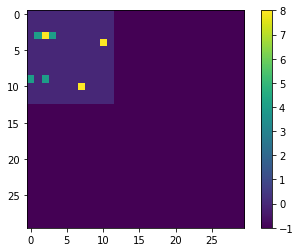

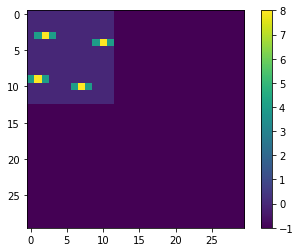

(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


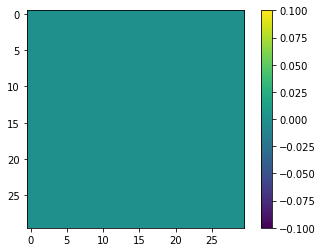

LOSS AT EPOCH 0: 1.4770371 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


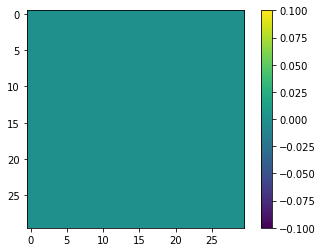

LOSS AT EPOCH 0: 1.4770371 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


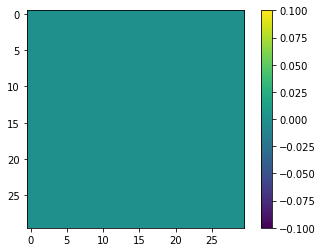

LOSS AT EPOCH 5: 1.4499991 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


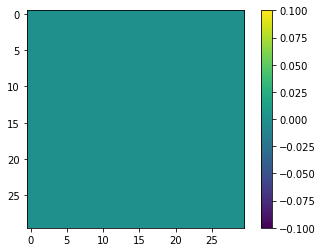

LOSS AT EPOCH 5: 1.4468374 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


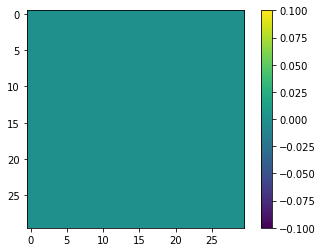

LOSS AT EPOCH 10: 1.4008996 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


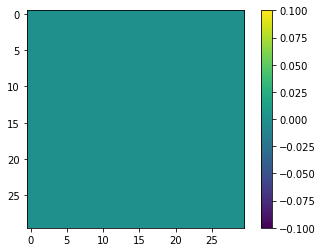

LOSS AT EPOCH 10: 1.3873029 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


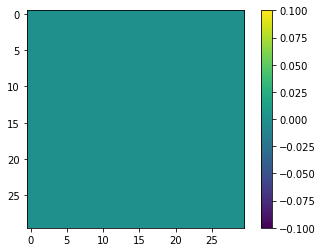

LOSS AT EPOCH 15: 1.3110784 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[256 144 251 323] [286 156 266 361]


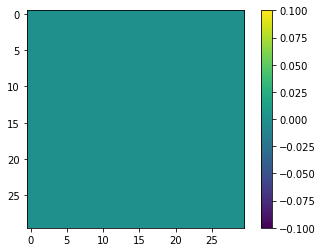

LOSS AT EPOCH 15: 1.2777996 TRAIN ACCURACY: 2.7617908407382092 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[248 144 251 323] [286 156 266 361]


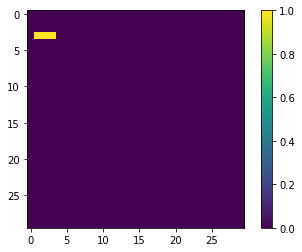

LOSS AT EPOCH 20: 1.1569444 TRAIN ACCURACY: 2.7338188127661813 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[249 144 251 323] [286 156 266 361]


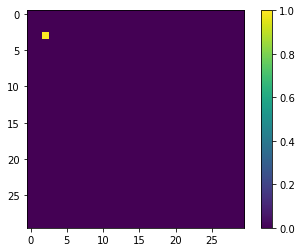

LOSS AT EPOCH 20: 1.0933497 TRAIN ACCURACY: 2.7373153162626847 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[233 131 232 308] [286 156 266 361]


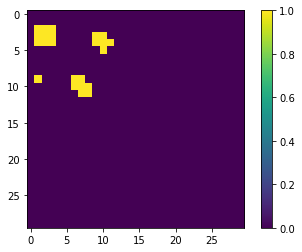

LOSS AT EPOCH 25: 0.91463774 TRAIN ACCURACY: 2.526609355556724 VALIDATION ACCURACY: 0.853185595567867
(4, 30, 30, 8)
[243 138 240 321] [286 156 266 361]


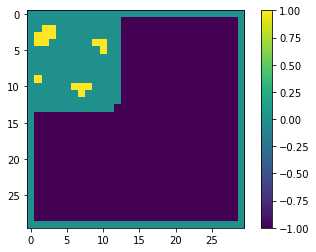

LOSS AT EPOCH 25: 0.8199776 TRAIN ACCURACY: 2.6365213733634785 VALIDATION ACCURACY: 0.889196675900277
(4, 30, 30, 8)
[210 113 223 277] [286 156 266 361]


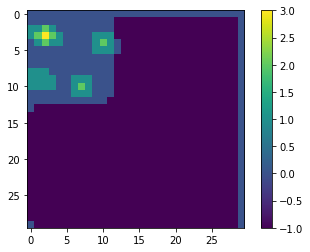

LOSS AT EPOCH 30: 0.60105073 TRAIN ACCURACY: 2.296970573286363 VALIDATION ACCURACY: 0.7673130193905817
(4, 30, 30, 8)
[215 118 229 287] [286 156 266 361]


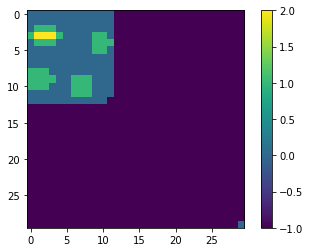

LOSS AT EPOCH 30: 0.55062044 TRAIN ACCURACY: 2.3690607637976058 VALIDATION ACCURACY: 0.7950138504155124
(4, 30, 30, 8)
[201 102 207 239] [286 156 266 361]


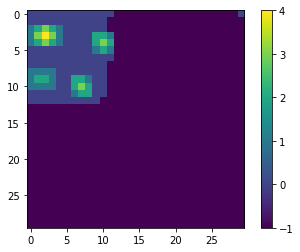

LOSS AT EPOCH 35: 0.5345583 TRAIN ACCURACY: 2.134838845365161 VALIDATION ACCURACY: 0.6620498614958449
(4, 30, 30, 8)
[201 105 207 240] [286 156 266 361]


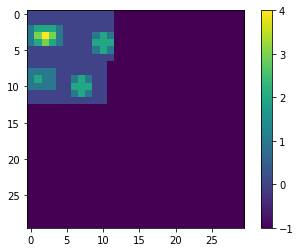

LOSS AT EPOCH 35: 0.54709303 TRAIN ACCURACY: 2.1540696145959304 VALIDATION ACCURACY: 0.6648199445983379
(4, 30, 30, 8)
[207 103 209 248] [286 156 266 361]


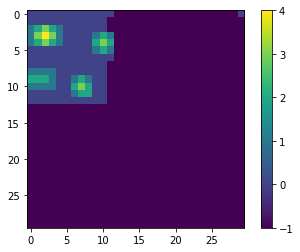

LOSS AT EPOCH 40: 0.47465843 TRAIN ACCURACY: 2.1697469197469195 VALIDATION ACCURACY: 0.6869806094182825
(4, 30, 30, 8)
[212 110 217 251] [286 156 266 361]


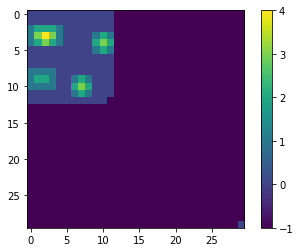

LOSS AT EPOCH 40: 0.469598 TRAIN ACCURACY: 2.262176420071157 VALIDATION ACCURACY: 0.6952908587257618
(4, 30, 30, 8)
[212 111 221 273] [286 156 266 361]


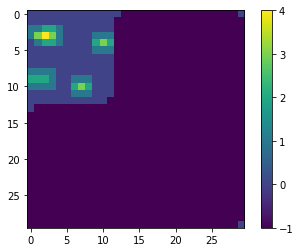

LOSS AT EPOCH 45: 0.426856 TRAIN ACCURACY: 2.283624270466376 VALIDATION ACCURACY: 0.7562326869806094
(4, 30, 30, 8)
[212 115 222 277] [286 156 266 361]


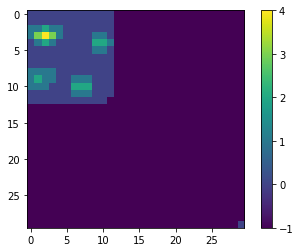

LOSS AT EPOCH 45: 0.43948537 TRAIN ACCURACY: 2.313024694603642 VALIDATION ACCURACY: 0.7673130193905817
(4, 30, 30, 8)
[215 113 222 280] [286 156 266 361]


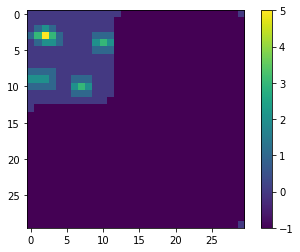

LOSS AT EPOCH 50: 0.40459415 TRAIN ACCURACY: 2.3106936922726398 VALIDATION ACCURACY: 0.775623268698061
(4, 30, 30, 8)
[219 122 228 289] [286 156 266 361]


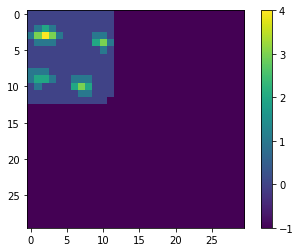

LOSS AT EPOCH 50: 0.4083563 TRAIN ACCURACY: 2.404928404928405 VALIDATION ACCURACY: 0.8005540166204986
(4, 30, 30, 8)
[216 116 223 284] [286 156 266 361]


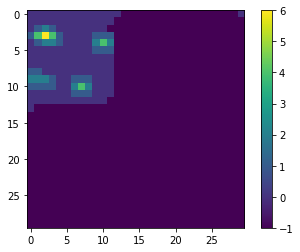

LOSS AT EPOCH 55: 0.35421842 TRAIN ACCURACY: 2.337180363496153 VALIDATION ACCURACY: 0.7867036011080333
(4, 30, 30, 8)
[223 124 227 288] [286 156 266 361]


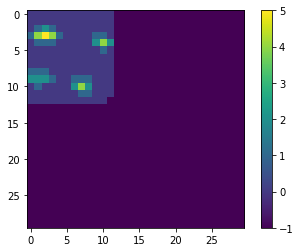

LOSS AT EPOCH 55: 0.3660204 TRAIN ACCURACY: 2.427975533238691 VALIDATION ACCURACY: 0.7977839335180056
(4, 30, 30, 8)
[225 117 223 286] [286 156 266 361]


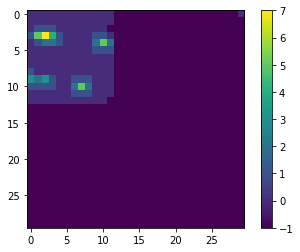

LOSS AT EPOCH 60: 0.3156796 TRAIN ACCURACY: 2.375059151374941 VALIDATION ACCURACY: 0.7922437673130194
(4, 30, 30, 8)
[231 124 229 294] [286 156 266 361]


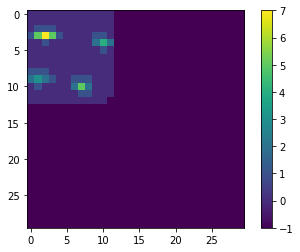

LOSS AT EPOCH 60: 0.328402 TRAIN ACCURACY: 2.4634663582032004 VALIDATION ACCURACY: 0.814404432132964
(4, 30, 30, 8)
[236 128 238 306] [286 156 266 361]


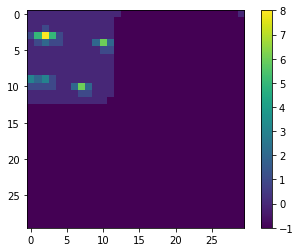

LOSS AT EPOCH 65: 0.28859386 TRAIN ACCURACY: 2.540424487792909 VALIDATION ACCURACY: 0.8476454293628809
(4, 30, 30, 8)
[240 132 237 308] [286 156 266 361]


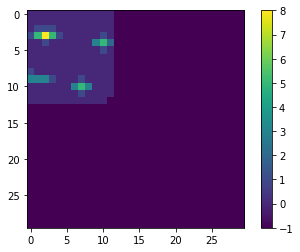

LOSS AT EPOCH 65: 0.29639605 TRAIN ACCURACY: 2.5762921289237077 VALIDATION ACCURACY: 0.853185595567867
(4, 30, 30, 8)
[239 138 239 314] [286 156 266 361]


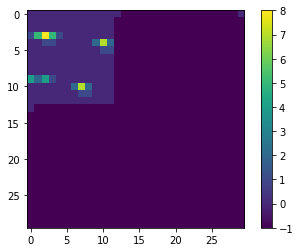

LOSS AT EPOCH 70: 0.26999572 TRAIN ACCURACY: 2.6187759608812238 VALIDATION ACCURACY: 0.8698060941828255
(4, 30, 30, 8)
[242 139 245 314] [286 156 266 361]


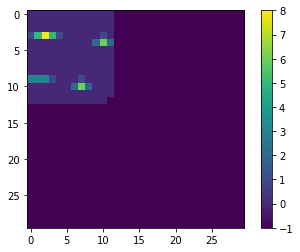

LOSS AT EPOCH 70: 0.2760053 TRAIN ACCURACY: 2.6582321187584346 VALIDATION ACCURACY: 0.8698060941828255
(4, 30, 30, 8)
[246 139 246 324] [286 156 266 361]


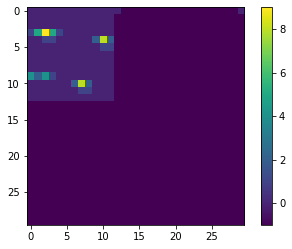

LOSS AT EPOCH 75: 0.26065078 TRAIN ACCURACY: 2.6759775312406893 VALIDATION ACCURACY: 0.8975069252077562
(4, 30, 30, 8)
[241 138 247 321] [286 156 266 361]


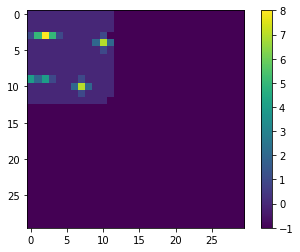

LOSS AT EPOCH 75: 0.2635603 TRAIN ACCURACY: 2.655844155844156 VALIDATION ACCURACY: 0.889196675900277
(4, 30, 30, 8)
[248 139 246 327] [286 156 266 361]


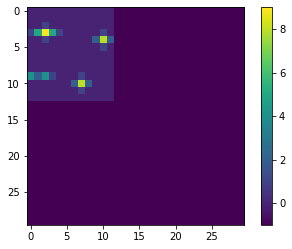

LOSS AT EPOCH 80: 0.2558318 TRAIN ACCURACY: 2.682970538233696 VALIDATION ACCURACY: 0.9058171745152355
(4, 30, 30, 8)
[242 137 245 323] [286 156 266 361]


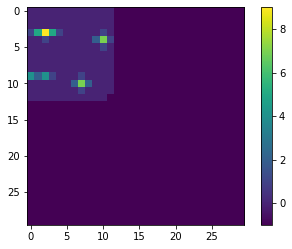

LOSS AT EPOCH 80: 0.2557267 TRAIN ACCURACY: 2.645411605937922 VALIDATION ACCURACY: 0.8947368421052632
(4, 30, 30, 8)
[248 138 244 327] [286 156 266 361]


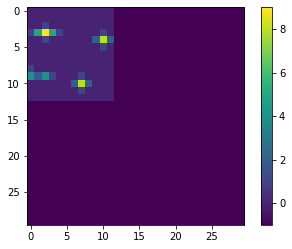

LOSS AT EPOCH 85: 0.2527306 TRAIN ACCURACY: 2.6690414848309585 VALIDATION ACCURACY: 0.9058171745152355
(4, 30, 30, 8)
[245 138 247 322] [286 156 266 361]


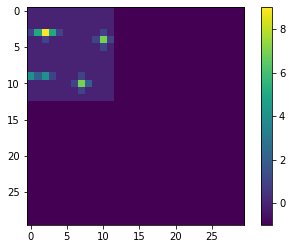

LOSS AT EPOCH 85: 0.2528856 TRAIN ACCURACY: 2.6698301698301696 VALIDATION ACCURACY: 0.8919667590027701
(4, 30, 30, 8)
[249 139 244 329] [286 156 266 361]


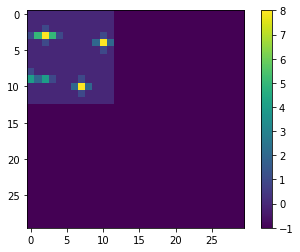

LOSS AT EPOCH 90: 0.2494164 TRAIN ACCURACY: 2.6789482447377186 VALIDATION ACCURACY: 0.9113573407202216
(4, 30, 30, 8)
[247 140 248 326] [286 156 266 361]


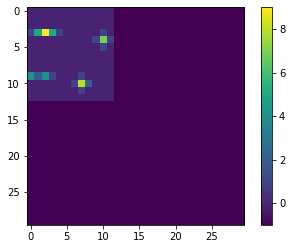

LOSS AT EPOCH 90: 0.24974881 TRAIN ACCURACY: 2.69340308813993 VALIDATION ACCURACY: 0.9030470914127424
(4, 30, 30, 8)
[249 139 244 329] [286 156 266 361]


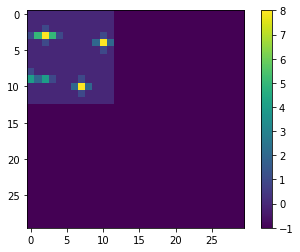

LOSS AT EPOCH 95: 0.24665518 TRAIN ACCURACY: 2.6789482447377186 VALIDATION ACCURACY: 0.9113573407202216
(4, 30, 30, 8)
[247 141 251 327] [286 156 266 361]


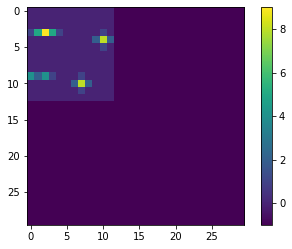

LOSS AT EPOCH 95: 0.24643753 TRAIN ACCURACY: 2.7110915400389084 VALIDATION ACCURACY: 0.9058171745152355
(4, 30, 30, 8)
[248 139 244 329] [286 156 266 361]


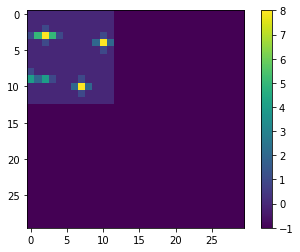

LOSS AT EPOCH 100: 0.24452114 TRAIN ACCURACY: 2.675451741241215 VALIDATION ACCURACY: 0.9113573407202216
(4, 30, 30, 8)
[247 141 251 326] [286 156 266 361]


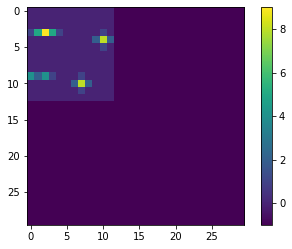

LOSS AT EPOCH 100: 0.24392937 TRAIN ACCURACY: 2.7110915400389084 VALIDATION ACCURACY: 0.9030470914127424


In [ ]:
ntasks = 5
channels = 8
filters = 20
perceptionsize = 3
neurons = 128
epochs = 300
iterations = 100

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

model1 = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

models = [model, model1]

task = names[257]
ctask = load(task)
print(len(ctask[0]))
plot(ctask[0][1])
plot(ctask[1][1])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
models = train(models, cin, epochs, iterations, channels, True, True, ctask)

Define model.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((3, 3), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(128, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

In [ ]:
current = 10

ctask = load(names[current])
plot(ctask[0][0])
plot(ctask[1][0])

In [ ]:
plot(np.clip(np.round(out), -1, 9))
plot(ctask[1][1])

In [ ]:
testacc(np.clip(np.round(out), -1, 9), ctask[1][1])